In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ffpnjlvb
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ffpnjlvb
     |████████████████████████████████| 58 kB 4.4 MB/s 
     |████████████████████████████████| 376 kB 18.4 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.1-py3-none-any.whl size=88649 sha256=3c4e64ede0fb94e85dae09fa3aeec4f844ef477cc82ecad0265d97d082e5ffb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-85wbb1gs/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=ad30e507f62d0f02577a808b3fb08da68a178a5438669fe989b4947367d1db40
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

In [ ]:
!pip install einops

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 713 kB 10.1 MB/s 


In [ ]:
path0 = '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem' # replace your data path
dpiv = 80

In [ ]:
import monai
from monai.optimizers import LearningRateFinder
from monai.inferers import SimpleInferer
from monai.metrics import DiceMetric
import monai.transforms as mtf
from monai.networks import one_hot
from monai.data import decollate_batch
import albumentations as A
#from albumentations.pytorch import ToTensorV2

In [ ]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    CenterSpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    MapTransform,
    RandGaussianNoise,
    RandGaussianSharpen,
    HistogramNormalize,
    ToNumpyd,
    RandBiasField,
    RandAdjustContrast,
    RandAdjustContrastd,
    RandBiasFieldd,
    RandZoom,
    RandShiftIntensity,
    ToTensord,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.nets import UNETR
from monai.networks.nets import BasicUNet
from monai.networks.nets import EfficientNetBN
from monai.networks.nets import VNet
from monai.networks.nets import RegUNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

200

In [ ]:
print(path_list)

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_13_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_19_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_4_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_7_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_23_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_26_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_17_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_11_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_21_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_2_1', '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem

### data split (train/valid)

In [ ]:
train_ind = np.arange(0,160)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [ ]:
valid_ind = np.arange(160,200)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [ ]:
train_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      #RandAdjustContrast(prob=0.1, gamma=(0.5, 4.5)),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 64],random_size=False),
      #RandZoom(keys=["image", "label"],prob=0.1, min_zoom=0.7, max_zoom=1.3),
      #ToNumpyd(keys=["image", "label"]),
      RandBiasFieldd(keys=["image"],degree=3, coeff_range=(0.0, 0.1),prob=0.1),
      RandAdjustContrastd(keys=["image"],prob=0.1, gamma=(0.5, 4.5)),
      ToTensord(keys=["image", "label"]),
      #RandGaussianNoise(prob=0.1, mean=0.0, std=0.1),
    ]
)

valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image", "label"]),
    ]
)


test_transforms = Compose(
    [
      LoadImaged(keys=("image")),
      AddChanneld(keys=("image")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys= ["image"]),
    ]
)


In [ ]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 3)

In [ ]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

- transform이 제대로 적용되는 지 확인해 봅니다.

torch.Size([3, 1, 160, 160, 64])
torch.Size([3, 1, 160, 160, 64])


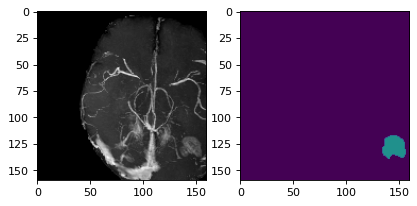

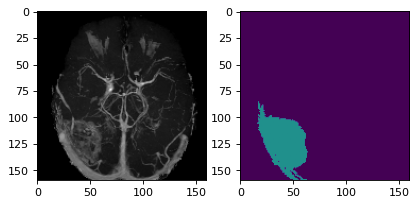

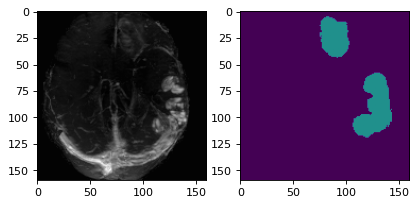

In [ ]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=dpiv)
    plt.subplot(121)
    plt.imshow(np.transpose(np.max(data["image"][n,0,:,:,:].numpy(),axis=2),(1,0)),cmap='gray')

    label = (data["label"]==1).type(torch.FloatTensor) + (data["label"]==4).type(torch.FloatTensor) 
    plt.subplot(122)
    plt.imshow(np.transpose(np.max(label[n,0,:,:,:].numpy(),axis=2),(1,0)),vmin=0,vmax=2)
    plt.show()

  break
 

# Model

In [ ]:
device = torch.device("cuda:0")
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

In [ ]:
arch = "Unet"

In [ ]:
if arch == "Unet":
  model = UNet(dimensions=3,in_channels=1,out_channels=2,channels=(8, 16, 32, 64,128),strides=(2, 2, 2, 2),num_res_units=3,norm=Norm.BATCH,).to(device)
elif arch == "EfficientB3":
  model = EfficientNetBN("efficientnet-b3", in_channels=1, num_classes=2 ,spatial_dims=3).to(device)
elif arch == "UNETR":
  model = UNETR(in_channels=1, out_channels=2, img_size=160, feature_size=32, norm_name='batch', spatial_dims=3).to(device)
elif arch == "BasicUnet":
  model = BasicUNet(spatial_dims=3, features=(32, 32, 64, 128, 256, 32)).to(device)
elif arch == "VNet":
  model = VNet(spatial_dims=3, in_channels=1, out_channels=2, act=('elu', {'inplace': True}), dropout_prob=0.5, dropout_dim=3, bias=False).to(device)


In [ ]:
net = model.to(device)
print(type(net))
net

<class 'monai.networks.nets.unet.UNet'>


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
import torch
from torch import nn
from torchsummary import summary as summary_
from torch.nn import functional as F
from einops import rearrange, reduce, repeat

In [ ]:
summary_(model,(1,160,160,64),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1         [1, 8, 80, 80, 32]             224
            Conv3d-2         [1, 8, 80, 80, 32]             224
       BatchNorm3d-3         [1, 8, 80, 80, 32]              16
           Dropout-4         [1, 8, 80, 80, 32]               0
             PReLU-5         [1, 8, 80, 80, 32]               1
            Conv3d-6         [1, 8, 80, 80, 32]           1,736
       BatchNorm3d-7         [1, 8, 80, 80, 32]              16
           Dropout-8         [1, 8, 80, 80, 32]               0
             PReLU-9         [1, 8, 80, 80, 32]               1
           Conv3d-10         [1, 8, 80, 80, 32]           1,736
      BatchNorm3d-11         [1, 8, 80, 80, 32]              16
          Dropout-12         [1, 8, 80, 80, 32]               0
            PReLU-13         [1, 8, 80, 80, 32]               1
     ResidualUnit-14         [1, 8, 80,

In [ ]:
model = model.to(device)
# loss_function = monai.losses.DiceCELoss(include_background=False, softmax = True, to_onehot_y = True, ce_weight = torch.tensor([0.3, 0.3,0.4]).cuda())
loss_function = monai.losses.GeneralizedDiceLoss(include_background=False, softmax = True, to_onehot_y = True)
post_trans = mtf.Compose(
    [mtf.Activations(softmax=True)]
)
post_label = mtf.AsDiscrete(to_onehot=True, n_classes=2)
post_pred = mtf.AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
inferer = monai.inferers.SimpleInferer()

/usr/local/lib/python3.7/dist-packages/monai/transforms/post/array.py:177: UserWarning: `to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
  warnings.warn("`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.")


# Train

----------
epoch 1/200
epoch 1 average loss: 0.5876
----------
epoch 2/200
epoch 2 average loss: 0.4647
----------
epoch 3/200
epoch 3 average loss: 0.3831
----------
epoch 4/200
epoch 4 average loss: 0.3060
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_473_1_pro/t1ce.nii.gz']


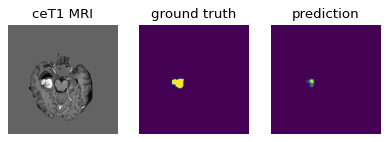

saved new best metric model
current epoch: 4 current mean dice: 0.5854
best mean dice: 0.5854 at epoch: 4
----------
epoch 5/200
epoch 5 average loss: 0.2937
----------
epoch 6/200
epoch 6 average loss: 0.2819
----------
epoch 7/200
epoch 7 average loss: 0.2854
----------
epoch 8/200
epoch 8 average loss: 0.2653
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA06_332_1_pro/t1ce.nii.gz']


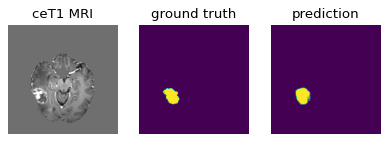

saved new best metric model
current epoch: 8 current mean dice: 0.7868
best mean dice: 0.7868 at epoch: 8
----------
epoch 9/200
epoch 9 average loss: 0.2484
----------
epoch 10/200
epoch 10 average loss: 0.2388
----------
epoch 11/200
epoch 11 average loss: 0.2324
----------
epoch 12/200
epoch 12 average loss: 0.2115
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_378_1_pro/t1ce.nii.gz']


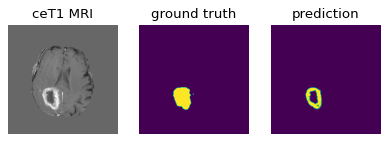

current epoch: 12 current mean dice: 0.6904
best mean dice: 0.7868 at epoch: 8
----------
epoch 13/200
epoch 13 average loss: 0.1984
----------
epoch 14/200
epoch 14 average loss: 0.1836
----------
epoch 15/200
epoch 15 average loss: 0.2085
----------
epoch 16/200
epoch 16 average loss: 0.1772
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_121_1_pro/t1ce.nii.gz']


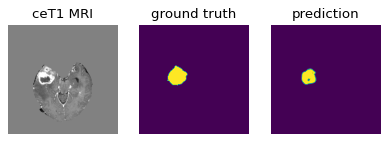

current epoch: 16 current mean dice: 0.6888
best mean dice: 0.7868 at epoch: 8
----------
epoch 17/200
epoch 17 average loss: 0.1996
----------
epoch 18/200
epoch 18 average loss: 0.1773
----------
epoch 19/200
epoch 19 average loss: 0.1984
----------
epoch 20/200
epoch 20 average loss: 0.1761
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_111_1_pro/t1ce.nii.gz']


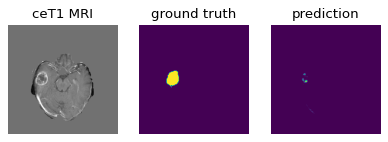

current epoch: 20 current mean dice: 0.5654
best mean dice: 0.7868 at epoch: 8
----------
epoch 21/200
epoch 21 average loss: 0.1615
----------
epoch 22/200
epoch 22 average loss: 0.1480
----------
epoch 23/200
epoch 23 average loss: 0.1501
----------
epoch 24/200
epoch 24 average loss: 0.1488
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_257_1_pro/t1ce.nii.gz']


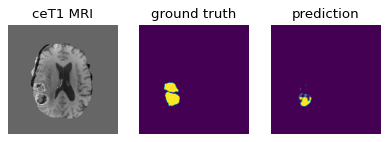

saved new best metric model
current epoch: 24 current mean dice: 0.8096
best mean dice: 0.8096 at epoch: 24
----------
epoch 25/200
epoch 25 average loss: 0.1542
----------
epoch 26/200
epoch 26 average loss: 0.1527
----------
epoch 27/200
epoch 27 average loss: 0.1714
----------
epoch 28/200
epoch 28 average loss: 0.1359
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA05_444_1_pro/t1ce.nii.gz']


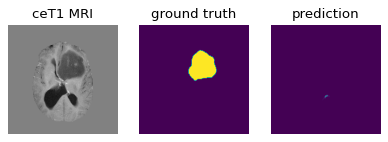

saved new best metric model
current epoch: 28 current mean dice: 0.8496
best mean dice: 0.8496 at epoch: 28
----------
epoch 29/200
epoch 29 average loss: 0.1412
----------
epoch 30/200
epoch 30 average loss: 0.1319
----------
epoch 31/200
epoch 31 average loss: 0.1441
----------
epoch 32/200
epoch 32 average loss: 0.1216
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_278_1_pro/t1ce.nii.gz']


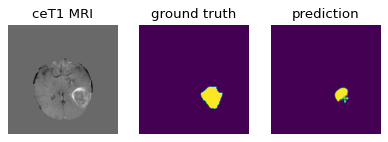

current epoch: 32 current mean dice: 0.8218
best mean dice: 0.8496 at epoch: 28
----------
epoch 33/200
epoch 33 average loss: 0.1366
----------
epoch 34/200
epoch 34 average loss: 0.1200
----------
epoch 35/200
epoch 35 average loss: 0.1612
----------
epoch 36/200
epoch 36 average loss: 0.1449
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_401_1_pro/t1ce.nii.gz']


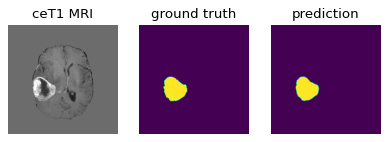

saved new best metric model
current epoch: 36 current mean dice: 0.8626
best mean dice: 0.8626 at epoch: 36
----------
epoch 37/200
epoch 37 average loss: 0.1220
----------
epoch 38/200
epoch 38 average loss: 0.1249
----------
epoch 39/200
epoch 39 average loss: 0.1192
----------
epoch 40/200
epoch 40 average loss: 0.1117
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_138_1_pro/t1ce.nii.gz']


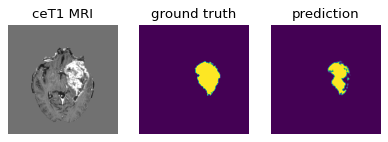

current epoch: 40 current mean dice: 0.8294
best mean dice: 0.8626 at epoch: 36
----------
epoch 41/200
epoch 41 average loss: 0.1376
----------
epoch 42/200
epoch 42 average loss: 0.1328
----------
epoch 43/200
epoch 43 average loss: 0.1134
----------
epoch 44/200
epoch 44 average loss: 0.1289
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_375_1_pro/t1ce.nii.gz']


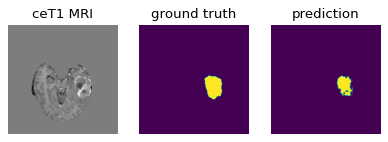

saved new best metric model
current epoch: 44 current mean dice: 0.8642
best mean dice: 0.8642 at epoch: 44
----------
epoch 45/200
epoch 45 average loss: 0.0990
----------
epoch 46/200
epoch 46 average loss: 0.1142
----------
epoch 47/200
epoch 47 average loss: 0.1056
----------
epoch 48/200
epoch 48 average loss: 0.1085
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_394_1_pro/t1ce.nii.gz']


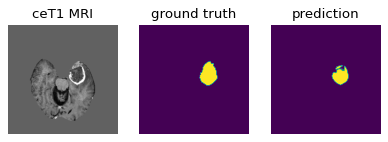

saved new best metric model
current epoch: 48 current mean dice: 0.8876
best mean dice: 0.8876 at epoch: 48
----------
epoch 49/200
epoch 49 average loss: 0.1088
----------
epoch 50/200
epoch 50 average loss: 0.0926
----------
epoch 51/200
epoch 51 average loss: 0.0933
----------
epoch 52/200
epoch 52 average loss: 0.1208
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_278_1_pro/t1ce.nii.gz']


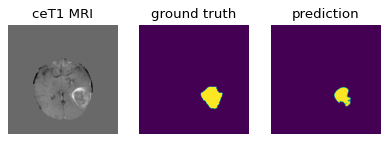

saved new best metric model
current epoch: 52 current mean dice: 0.9022
best mean dice: 0.9022 at epoch: 52
----------
epoch 53/200
epoch 53 average loss: 0.1225
----------
epoch 54/200
epoch 54 average loss: 0.1032
----------
epoch 55/200
epoch 55 average loss: 0.1082
----------
epoch 56/200
epoch 56 average loss: 0.1128
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_474_1_pro/t1ce.nii.gz']


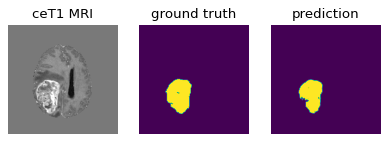

current epoch: 56 current mean dice: 0.8722
best mean dice: 0.9022 at epoch: 52
----------
epoch 57/200
epoch 57 average loss: 0.0988
----------
epoch 58/200
epoch 58 average loss: 0.0951
----------
epoch 59/200
epoch 59 average loss: 0.0931
----------
epoch 60/200
epoch 60 average loss: 0.0873
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA05_277_1_pro/t1ce.nii.gz']


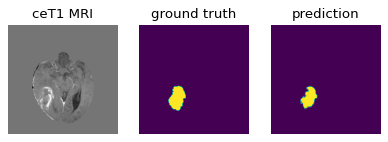

saved new best metric model
current epoch: 60 current mean dice: 0.9129
best mean dice: 0.9129 at epoch: 60
----------
epoch 61/200
epoch 61 average loss: 0.0870
----------
epoch 62/200
epoch 62 average loss: 0.0904
----------
epoch 63/200
epoch 63 average loss: 0.0931
----------
epoch 64/200
epoch 64 average loss: 0.0942
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_168_1_pro/t1ce.nii.gz']


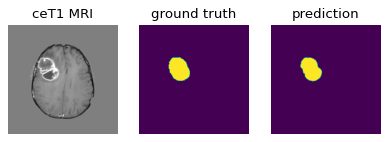

current epoch: 64 current mean dice: 0.9006
best mean dice: 0.9129 at epoch: 60
----------
epoch 65/200
epoch 65 average loss: 0.1041
----------
epoch 66/200
epoch 66 average loss: 0.0894
----------
epoch 67/200
epoch 67 average loss: 0.1045
----------
epoch 68/200
epoch 68 average loss: 0.0941
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_296_1_pro/t1ce.nii.gz']


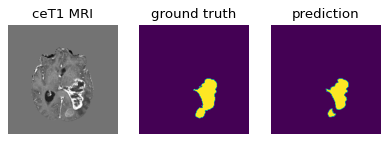

current epoch: 68 current mean dice: 0.9020
best mean dice: 0.9129 at epoch: 60
----------
epoch 69/200
epoch 69 average loss: 0.1035
----------
epoch 70/200
epoch 70 average loss: 0.0974
----------
epoch 71/200
epoch 71 average loss: 0.0852
----------
epoch 72/200
epoch 72 average loss: 0.0893
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_296_1_pro/t1ce.nii.gz']


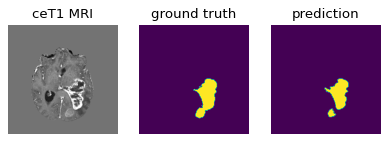

saved new best metric model
current epoch: 72 current mean dice: 0.9141
best mean dice: 0.9141 at epoch: 72
----------
epoch 73/200
epoch 73 average loss: 0.0922
----------
epoch 74/200
epoch 74 average loss: 0.1013
----------
epoch 75/200
epoch 75 average loss: 0.0881
----------
epoch 76/200
epoch 76 average loss: 0.0894
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_296_1_pro/t1ce.nii.gz']


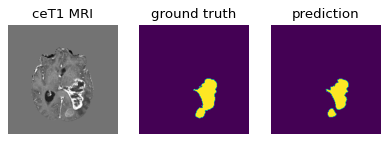

current epoch: 76 current mean dice: 0.9128
best mean dice: 0.9141 at epoch: 72
----------
epoch 77/200
epoch 77 average loss: 0.0942
----------
epoch 78/200
epoch 78 average loss: 0.0832
----------
epoch 79/200
epoch 79 average loss: 0.0798
----------
epoch 80/200
epoch 80 average loss: 0.0917
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA05_277_1_pro/t1ce.nii.gz']


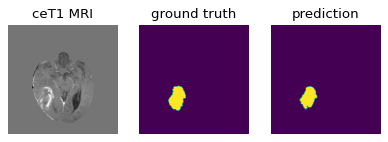

saved new best metric model
current epoch: 80 current mean dice: 0.9208
best mean dice: 0.9208 at epoch: 80
----------
epoch 81/200
epoch 81 average loss: 0.1015
----------
epoch 82/200
epoch 82 average loss: 0.0995
----------
epoch 83/200
epoch 83 average loss: 0.1014
----------
epoch 84/200
epoch 84 average loss: 0.0787
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_605_1_pro/t1ce.nii.gz']


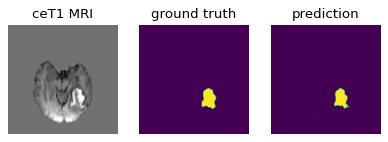

current epoch: 84 current mean dice: 0.9191
best mean dice: 0.9208 at epoch: 80
----------
epoch 85/200
epoch 85 average loss: 0.0819
----------
epoch 86/200
epoch 86 average loss: 0.0779
----------
epoch 87/200
epoch 87 average loss: 0.1010
----------
epoch 88/200
epoch 88 average loss: 0.0829
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_111_1_pro/t1ce.nii.gz']


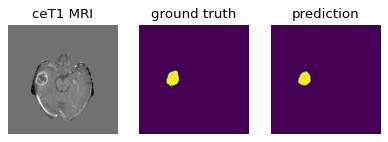

current epoch: 88 current mean dice: 0.9072
best mean dice: 0.9208 at epoch: 80
----------
epoch 89/200
epoch 89 average loss: 0.0740
----------
epoch 90/200
epoch 90 average loss: 0.0919
----------
epoch 91/200
epoch 91 average loss: 0.0819
----------
epoch 92/200
epoch 92 average loss: 0.0824
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_135_1_pro/t1ce.nii.gz']


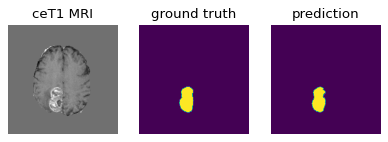

current epoch: 92 current mean dice: 0.9152
best mean dice: 0.9208 at epoch: 80
----------
epoch 93/200
epoch 93 average loss: 0.0726
----------
epoch 94/200
epoch 94 average loss: 0.0639
----------
epoch 95/200
epoch 95 average loss: 0.0733
----------
epoch 96/200
epoch 96 average loss: 0.0801
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_162_1_pro/t1ce.nii.gz']


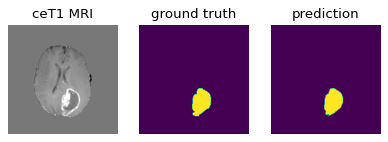

saved new best metric model
current epoch: 96 current mean dice: 0.9266
best mean dice: 0.9266 at epoch: 96
----------
epoch 97/200
epoch 97 average loss: 0.0745
----------
epoch 98/200
epoch 98 average loss: 0.0699
----------
epoch 99/200
epoch 99 average loss: 0.0798
----------
epoch 100/200
epoch 100 average loss: 0.0810
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA06_165_1_pro/t1ce.nii.gz']


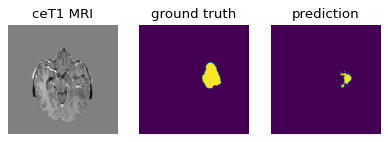

current epoch: 100 current mean dice: 0.9145
best mean dice: 0.9266 at epoch: 96
----------
epoch 101/200
epoch 101 average loss: 0.0884
----------
epoch 102/200
epoch 102 average loss: 0.0767
----------
epoch 103/200
epoch 103 average loss: 0.0729
----------
epoch 104/200
epoch 104 average loss: 0.0751
current epoch: 104 current mean dice: 0.9113
best mean dice: 0.9266 at epoch: 96
----------
epoch 105/200
epoch 105 average loss: 0.1057
----------
epoch 106/200
epoch 106 average loss: 0.1090
----------
epoch 107/200
epoch 107 average loss: 0.0928
----------
epoch 108/200
epoch 108 average loss: 0.0663
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_343_1_pro/t1ce.nii.gz']


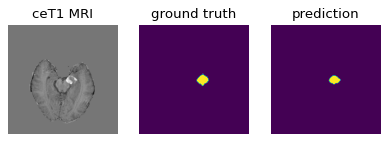

saved new best metric model
current epoch: 108 current mean dice: 0.9284
best mean dice: 0.9284 at epoch: 108
----------
epoch 109/200
epoch 109 average loss: 0.0746
----------
epoch 110/200
epoch 110 average loss: 0.0793
----------
epoch 111/200
epoch 111 average loss: 0.0782
----------
epoch 112/200
epoch 112 average loss: 0.0882
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_429_1_pro/t1ce.nii.gz']


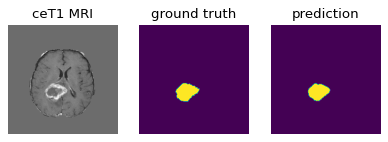

current epoch: 112 current mean dice: 0.9177
best mean dice: 0.9284 at epoch: 108
----------
epoch 113/200
epoch 113 average loss: 0.0721
----------
epoch 114/200
epoch 114 average loss: 0.0658
----------
epoch 115/200
epoch 115 average loss: 0.0808
----------
epoch 116/200
epoch 116 average loss: 0.0708
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_105_1_pro/t1ce.nii.gz']


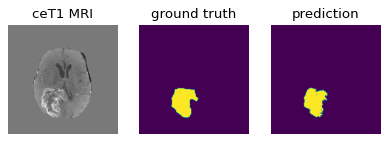

current epoch: 116 current mean dice: 0.9230
best mean dice: 0.9284 at epoch: 108
----------
epoch 117/200
epoch 117 average loss: 0.0698
----------
epoch 118/200
epoch 118 average loss: 0.0623
----------
epoch 119/200
epoch 119 average loss: 0.0729
----------
epoch 120/200
epoch 120 average loss: 0.0711
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_234_1_pro/t1ce.nii.gz']


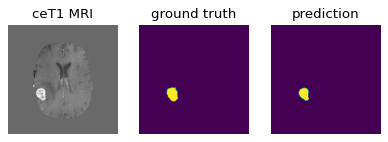

current epoch: 120 current mean dice: 0.8732
best mean dice: 0.9284 at epoch: 108
----------
epoch 121/200
epoch 121 average loss: 0.0704
----------
epoch 122/200
epoch 122 average loss: 0.0812
----------
epoch 123/200
epoch 123 average loss: 0.0731
----------
epoch 124/200
epoch 124 average loss: 0.0687
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_394_1_pro/t1ce.nii.gz']


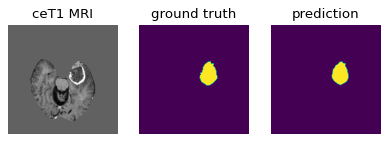

saved new best metric model
current epoch: 124 current mean dice: 0.9331
best mean dice: 0.9331 at epoch: 124
----------
epoch 125/200
epoch 125 average loss: 0.0666
----------
epoch 126/200
epoch 126 average loss: 0.0751
----------
epoch 127/200
epoch 127 average loss: 0.0731
----------
epoch 128/200
epoch 128 average loss: 0.0686
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_605_1_pro/t1ce.nii.gz']


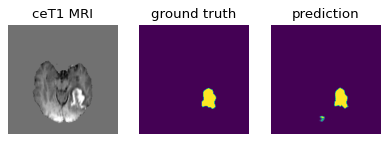

saved new best metric model
current epoch: 128 current mean dice: 0.9372
best mean dice: 0.9372 at epoch: 128
----------
epoch 129/200
epoch 129 average loss: 0.0710
----------
epoch 130/200
epoch 130 average loss: 0.0663
----------
epoch 131/200
epoch 131 average loss: 0.0714
----------
epoch 132/200
epoch 132 average loss: 0.0631
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_162_1_pro/t1ce.nii.gz']


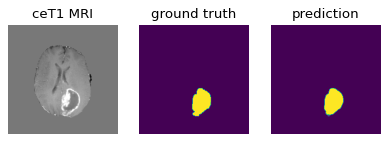

current epoch: 132 current mean dice: 0.9306
best mean dice: 0.9372 at epoch: 128
----------
epoch 133/200
epoch 133 average loss: 0.0625
----------
epoch 134/200
epoch 134 average loss: 0.0770
----------
epoch 135/200
epoch 135 average loss: 0.0674
----------
epoch 136/200
epoch 136 average loss: 0.0592
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_257_1_pro/t1ce.nii.gz']


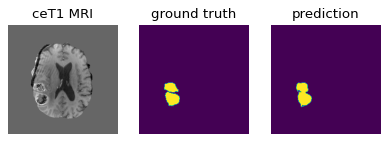

saved new best metric model
current epoch: 136 current mean dice: 0.9389
best mean dice: 0.9389 at epoch: 136
----------
epoch 137/200
epoch 137 average loss: 0.0721
----------
epoch 138/200
epoch 138 average loss: 0.0722
----------
epoch 139/200
epoch 139 average loss: 0.0656
----------
epoch 140/200
epoch 140 average loss: 0.0669
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_374_1_pro/t1ce.nii.gz']


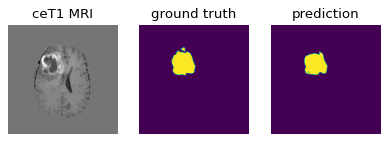

current epoch: 140 current mean dice: 0.9252
best mean dice: 0.9389 at epoch: 136
----------
epoch 141/200
epoch 141 average loss: 0.0729
----------
epoch 142/200
epoch 142 average loss: 0.0687
----------
epoch 143/200
epoch 143 average loss: 0.0770
----------
epoch 144/200
epoch 144 average loss: 0.0743
current epoch: 144 current mean dice: 0.9211
best mean dice: 0.9389 at epoch: 136
----------
epoch 145/200
epoch 145 average loss: 0.0630
----------
epoch 146/200
epoch 146 average loss: 0.0651
----------
epoch 147/200
epoch 147 average loss: 0.0704
----------
epoch 148/200
epoch 148 average loss: 0.0655
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_135_1_pro/t1ce.nii.gz']


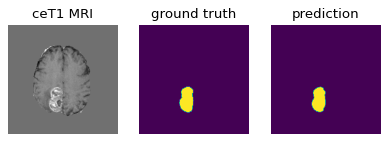

current epoch: 148 current mean dice: 0.9374
best mean dice: 0.9389 at epoch: 136
----------
epoch 149/200
epoch 149 average loss: 0.0688
----------
epoch 150/200
epoch 150 average loss: 0.0794
----------
epoch 151/200
epoch 151 average loss: 0.0669
----------
epoch 152/200
epoch 152 average loss: 0.0692
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_208_1_pro/t1ce.nii.gz']


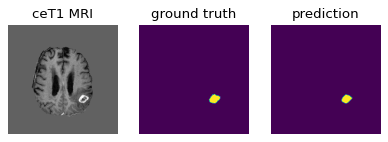

current epoch: 152 current mean dice: 0.9293
best mean dice: 0.9389 at epoch: 136
----------
epoch 153/200
epoch 153 average loss: 0.0646
----------
epoch 154/200
epoch 154 average loss: 0.0549
----------
epoch 155/200
epoch 155 average loss: 0.0584
----------
epoch 156/200
epoch 156 average loss: 0.0589
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_283_1_pro/t1ce.nii.gz']


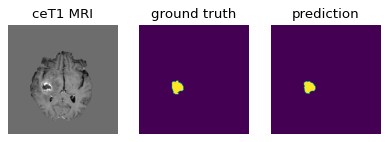

current epoch: 156 current mean dice: 0.9314
best mean dice: 0.9389 at epoch: 136
----------
epoch 157/200
epoch 157 average loss: 0.0621
----------
epoch 158/200
epoch 158 average loss: 0.0646
----------
epoch 159/200
epoch 159 average loss: 0.0652
----------
epoch 160/200
epoch 160 average loss: 0.0612
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_374_1_pro/t1ce.nii.gz']


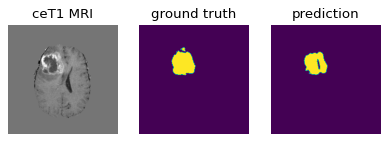

current epoch: 160 current mean dice: 0.9375
best mean dice: 0.9389 at epoch: 136
----------
epoch 161/200
epoch 161 average loss: 0.0640
----------
epoch 162/200
epoch 162 average loss: 0.0882
----------
epoch 163/200
epoch 163 average loss: 0.0891
----------
epoch 164/200
epoch 164 average loss: 0.0715
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_296_1_pro/t1ce.nii.gz']


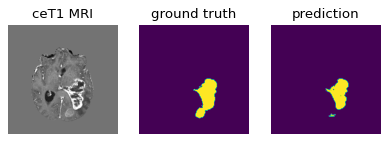

current epoch: 164 current mean dice: 0.9166
best mean dice: 0.9389 at epoch: 136
----------
epoch 165/200
epoch 165 average loss: 0.0684
----------
epoch 166/200
epoch 166 average loss: 0.0591
----------
epoch 167/200
epoch 167 average loss: 0.0659
----------
epoch 168/200
epoch 168 average loss: 0.0595
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_208_1_pro/t1ce.nii.gz']


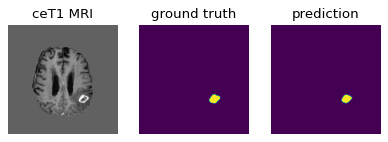

saved new best metric model
current epoch: 168 current mean dice: 0.9389
best mean dice: 0.9389 at epoch: 168
----------
epoch 169/200
epoch 169 average loss: 0.0629
----------
epoch 170/200
epoch 170 average loss: 0.0565
----------
epoch 171/200
epoch 171 average loss: 0.0553
----------
epoch 172/200
epoch 172 average loss: 0.0561
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_343_1_pro/t1ce.nii.gz']


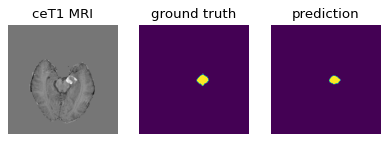

saved new best metric model
current epoch: 172 current mean dice: 0.9437
best mean dice: 0.9437 at epoch: 172
----------
epoch 173/200
epoch 173 average loss: 0.0598
----------
epoch 174/200
epoch 174 average loss: 0.0635
----------
epoch 175/200
epoch 175 average loss: 0.0761
----------
epoch 176/200
epoch 176 average loss: 0.0663
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_322_1_pro/t1ce.nii.gz']


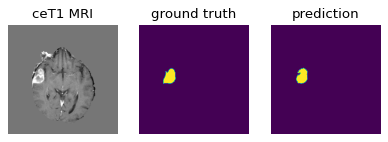

current epoch: 176 current mean dice: 0.9036
best mean dice: 0.9437 at epoch: 172
----------
epoch 177/200
epoch 177 average loss: 0.0687
----------
epoch 178/200
epoch 178 average loss: 0.0558
----------
epoch 179/200
epoch 179 average loss: 0.0570
----------
epoch 180/200
epoch 180 average loss: 0.0615
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_401_1_pro/t1ce.nii.gz']


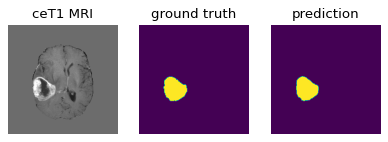

current epoch: 180 current mean dice: 0.9353
best mean dice: 0.9437 at epoch: 172
----------
epoch 181/200
epoch 181 average loss: 0.0685
----------
epoch 182/200
epoch 182 average loss: 0.0627
----------
epoch 183/200
epoch 183 average loss: 0.0578
----------
epoch 184/200
epoch 184 average loss: 0.0582
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA05_444_1_pro/t1ce.nii.gz']


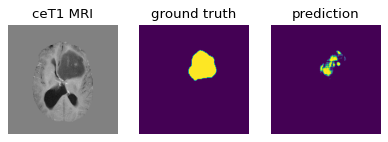

current epoch: 184 current mean dice: 0.9365
best mean dice: 0.9437 at epoch: 172
----------
epoch 185/200
epoch 185 average loss: 0.0719
----------
epoch 186/200
epoch 186 average loss: 0.0578
----------
epoch 187/200
epoch 187 average loss: 0.0528
----------
epoch 188/200
epoch 188 average loss: 0.0542
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_429_1_pro/t1ce.nii.gz']


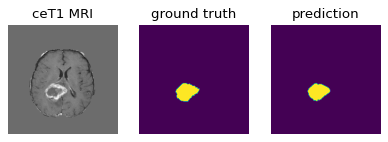

saved new best metric model
current epoch: 188 current mean dice: 0.9479
best mean dice: 0.9479 at epoch: 188
----------
epoch 189/200
epoch 189 average loss: 0.0565
----------
epoch 190/200
epoch 190 average loss: 0.0527
----------
epoch 191/200
epoch 191 average loss: 0.0596
----------
epoch 192/200
epoch 192 average loss: 0.0663
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_138_1_pro/t1ce.nii.gz']


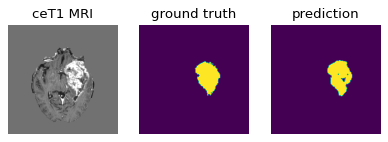

current epoch: 192 current mean dice: 0.9277
best mean dice: 0.9479 at epoch: 188
----------
epoch 193/200
epoch 193 average loss: 0.0626
----------
epoch 194/200
epoch 194 average loss: 0.0572
----------
epoch 195/200
epoch 195 average loss: 0.0589
----------
epoch 196/200
epoch 196 average loss: 0.0559
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_205_1_pro/t1ce.nii.gz']


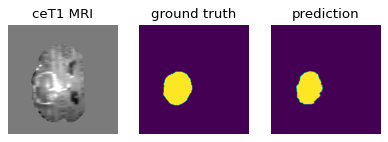

current epoch: 196 current mean dice: 0.9465
best mean dice: 0.9479 at epoch: 188
----------
epoch 197/200
epoch 197 average loss: 0.0647
----------
epoch 198/200
epoch 198 average loss: 0.0603
----------
epoch 199/200
epoch 199 average loss: 0.0654
----------
epoch 200/200
epoch 200 average loss: 0.0565
['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA05_444_1_pro/t1ce.nii.gz']


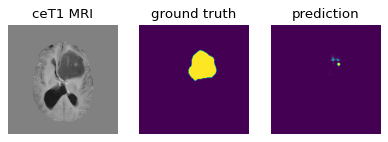

current epoch: 200 current mean dice: 0.9366
best mean dice: 0.9479 at epoch: 188


In [ ]:
root_dir = path0 # model will be saved in this folder

lr = 1e-3
max_epochs = 200
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

optimizer = torch.optim.Adam(model.parameters(), lr)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )

        labels = (labels==1).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor) + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_{best_metric_epoch}_ver7_data_200_UNet_12_08.pth"))    
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")

## plot the loss and metric

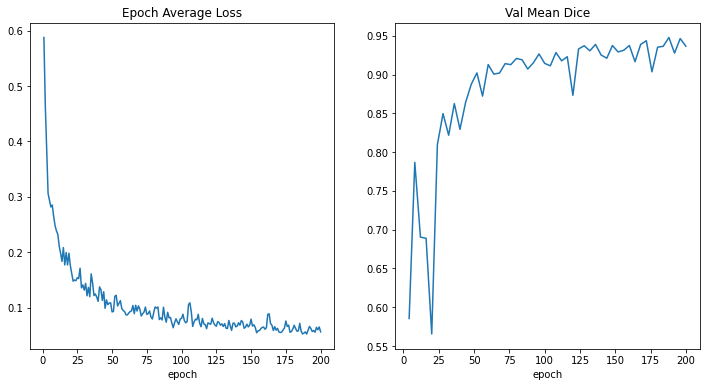

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Inference
- validation set 에 대해 가장 좋은 성능을 보여주었던 model을 불러와서 inference를 진행하고, 결과를 nifti파일로 저장합니다.

In [ ]:
import nibabel as nib
path_out = os.path.join(path0,'valid_out2') # the results will be saved in this folder
if os.path.isdir(path_out)==0:
  os.mkdir(path_out)

In [ ]:
root_dir = '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem'
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_epoch_140_ver6_data_200_UNet.pth")))

<All keys matched successfully>

In [ ]:
path1 = '/content/drive/MyDrive/21_2_Image_process_project/brats18_test' # replace your data path
dpiv = 80

In [ ]:
path_list = glob.glob(os.path.join(path1,'Brats18*'))
len(path_list)

20

In [ ]:
#따로 저장한거 에서 가져온다. 


test_ind = np.arange(0,20)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz")
    }
    for idx in test_ind
]
test_files =  data_dicts

In [ ]:
test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds,batch_size = 1)

In [ ]:
test_data = test_loader

In [ ]:
print(type(test_data))

<class 'monai.data.dataloader.DataLoader'>


In [ ]:
for val_data in val_test_data:
  #print(type(val_data))
  val_inputs, val_labels = (
                      val_data["image"].to(device),
                      val_data["label"],
                  )
  print(type(val_inputs))
  print(type(val_labels))        

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


KeyboardInterrupt: ignored

In [ ]:
for test_data in test_data:
  #print(type(val_data))
  ts_inputs =  test_data["image"].to(device)               
  
  print(type(ts_inputs))
 

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_378_1_pro/t1ce.nii.gz']


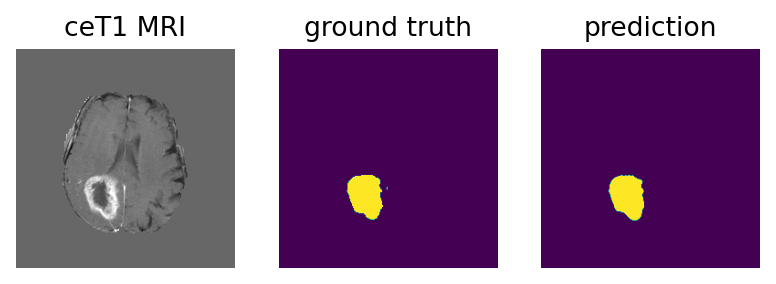

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_401_1_pro/t1ce.nii.gz']


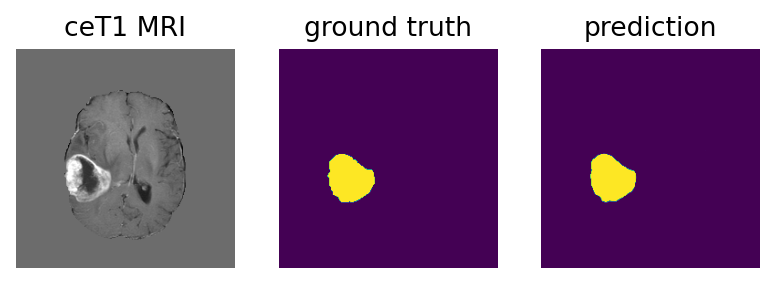

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_412_1_pro/t1ce.nii.gz']


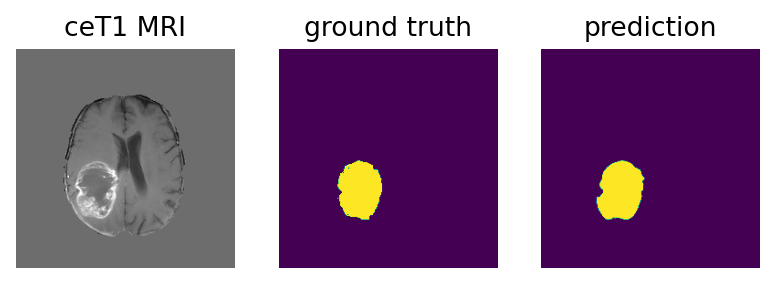

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA01_429_1_pro/t1ce.nii.gz']


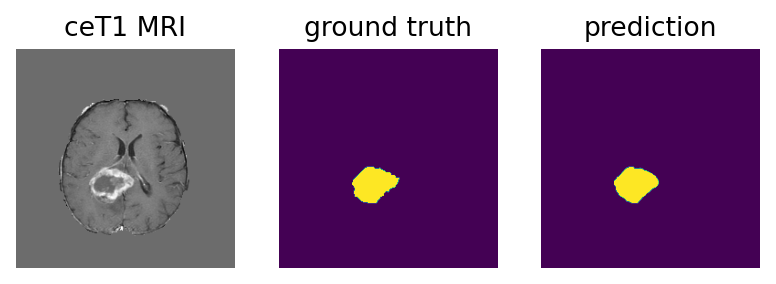

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_117_1_pro/t1ce.nii.gz']


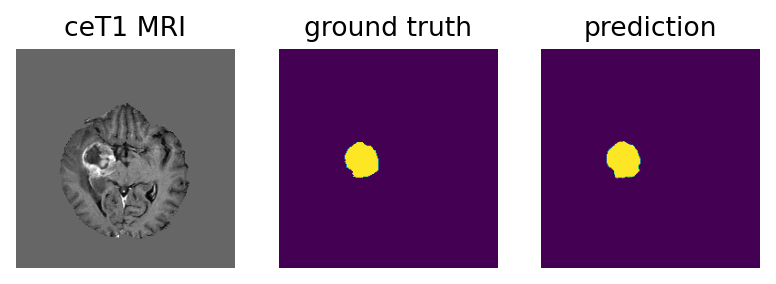

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_135_1_pro/t1ce.nii.gz']


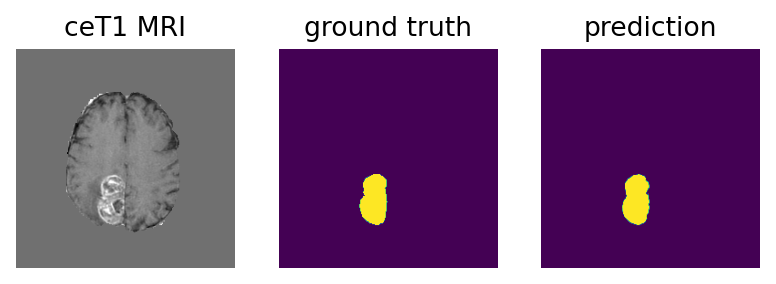

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_168_1_pro/t1ce.nii.gz']


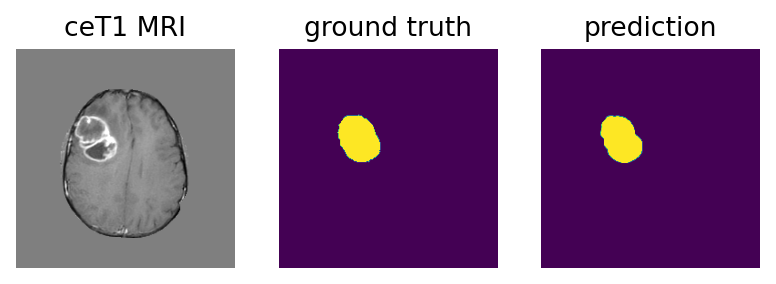

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_179_1_pro/t1ce.nii.gz']


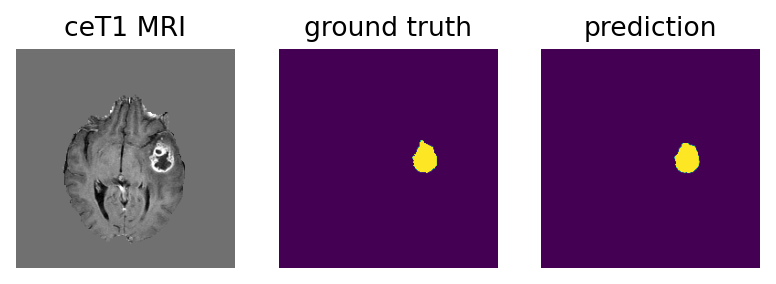

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_208_1_pro/t1ce.nii.gz']


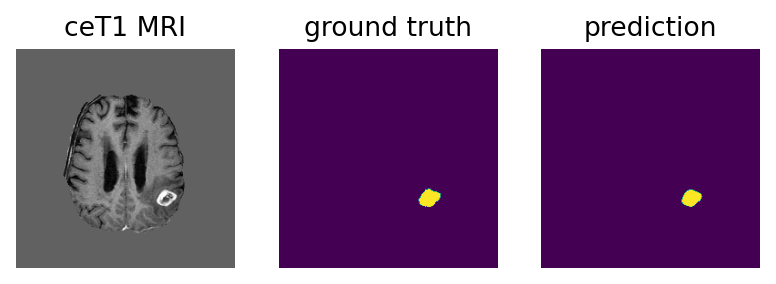

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_226_1_pro/t1ce.nii.gz']


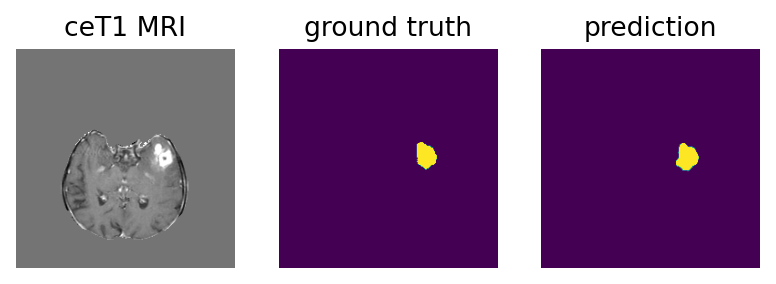

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_283_1_pro/t1ce.nii.gz']


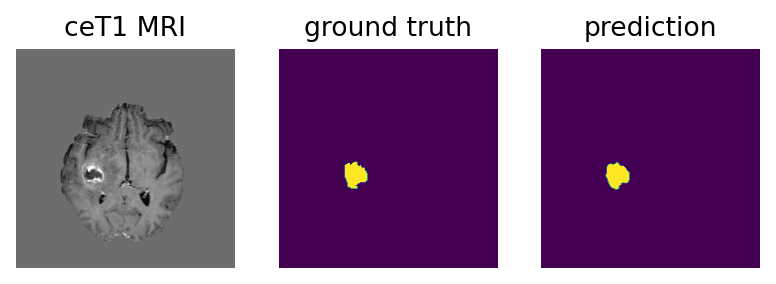

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_300_1_pro/t1ce.nii.gz']


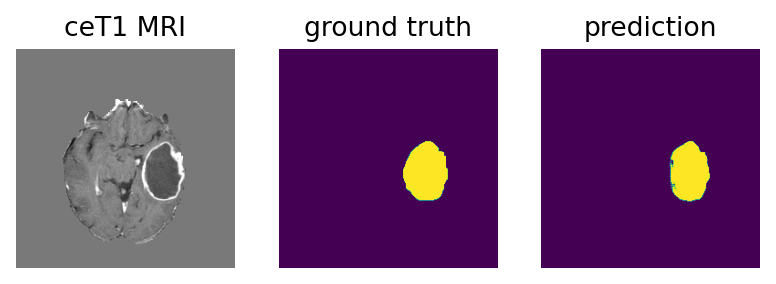

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_322_1_pro/t1ce.nii.gz']


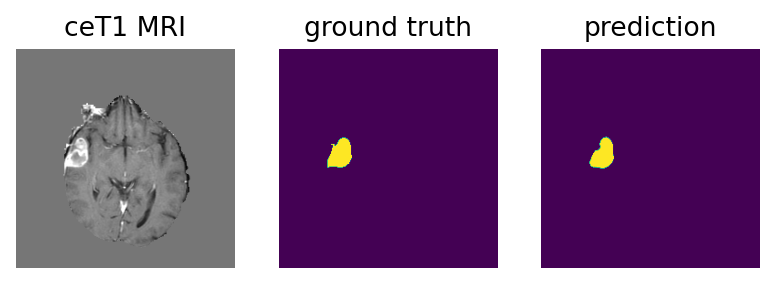

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_368_1_pro/t1ce.nii.gz']


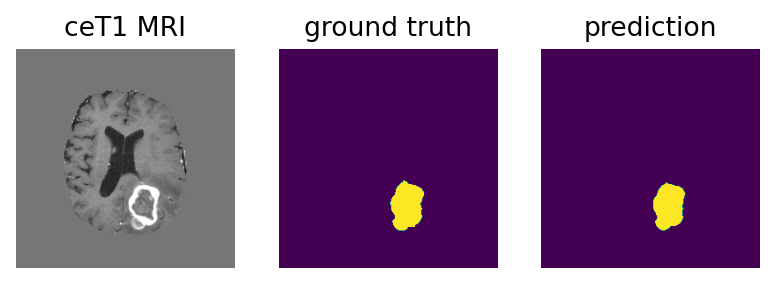

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_374_1_pro/t1ce.nii.gz']


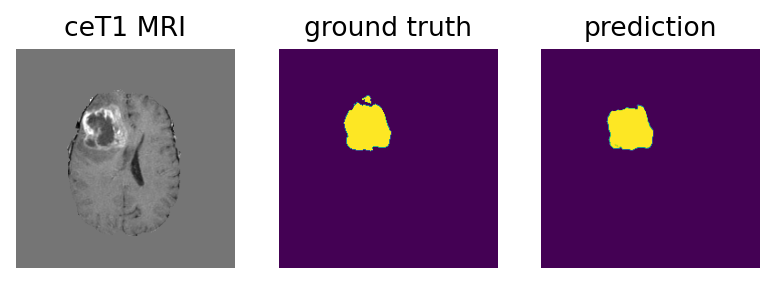

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_394_1_pro/t1ce.nii.gz']


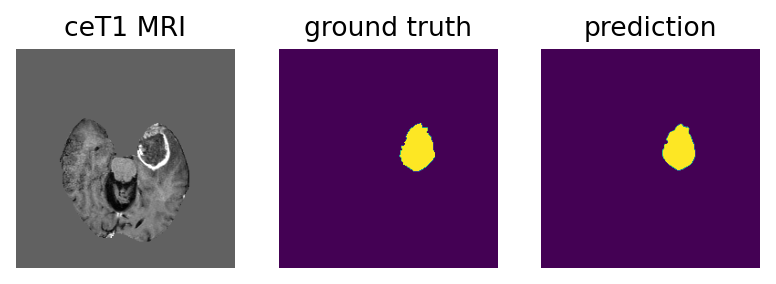

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_455_1_pro/t1ce.nii.gz']


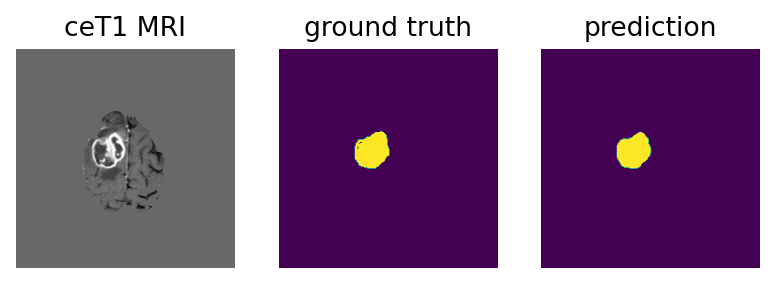

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_473_1_pro/t1ce.nii.gz']


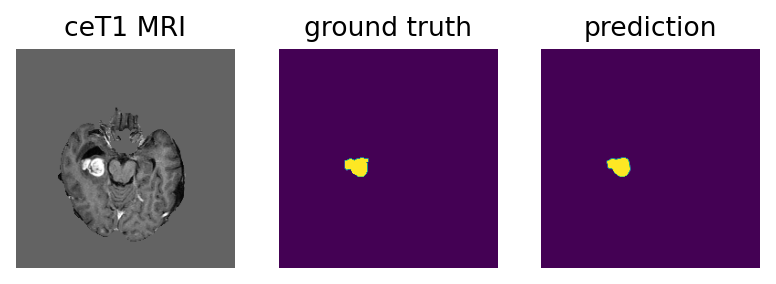

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA02_605_1_pro/t1ce.nii.gz']


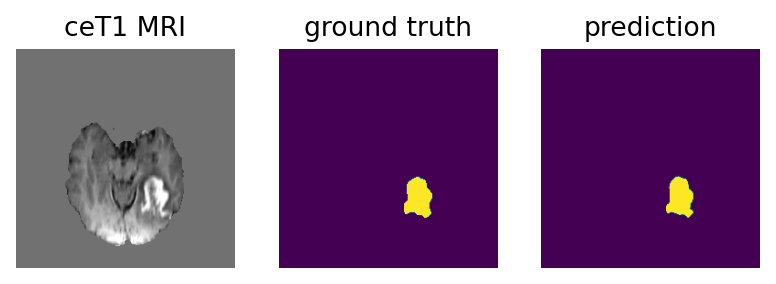

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_121_1_pro/t1ce.nii.gz']


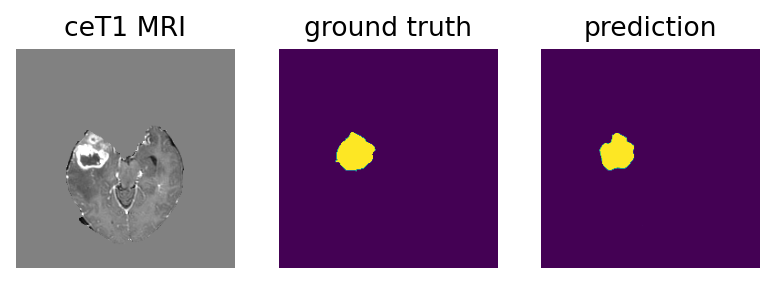

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_138_1_pro/t1ce.nii.gz']


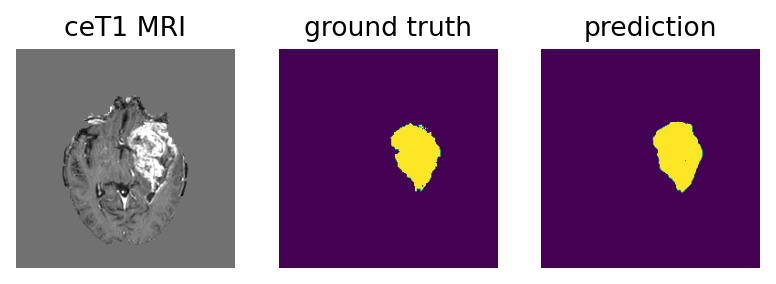

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_257_1_pro/t1ce.nii.gz']


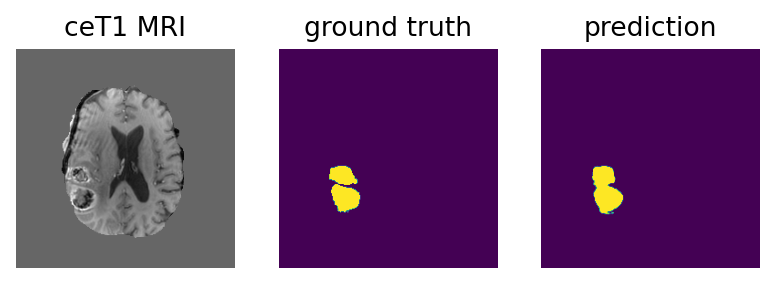

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_296_1_pro/t1ce.nii.gz']


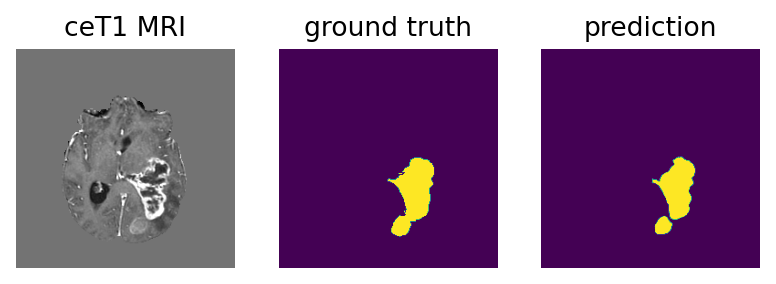

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_375_1_pro/t1ce.nii.gz']


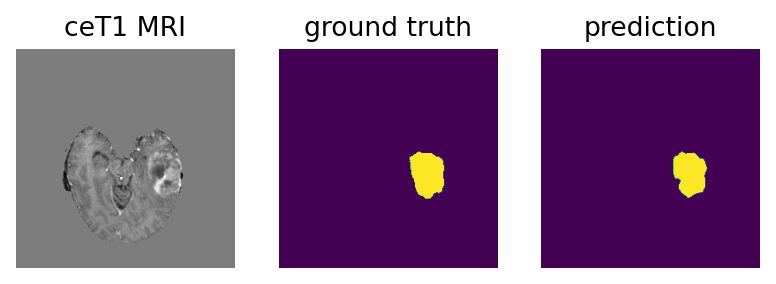

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA03_474_1_pro/t1ce.nii.gz']


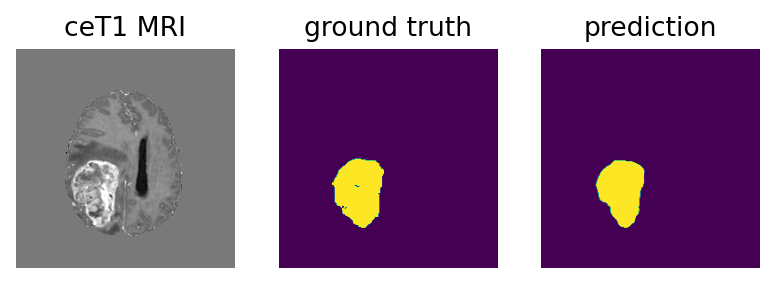

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_111_1_pro/t1ce.nii.gz']


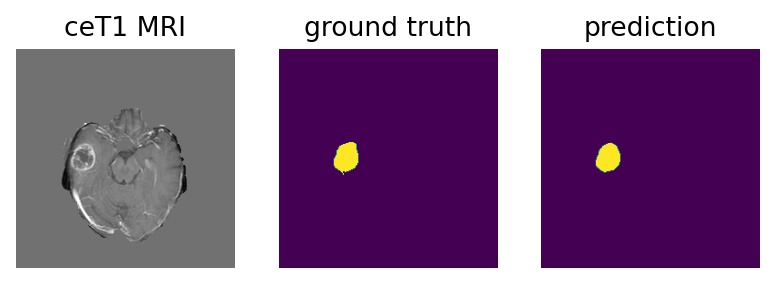

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_192_1_pro/t1ce.nii.gz']


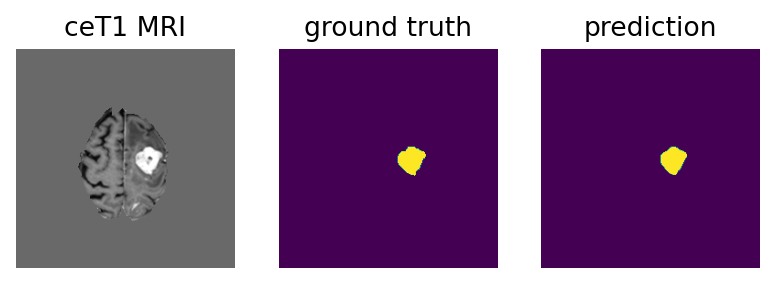

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_343_1_pro/t1ce.nii.gz']


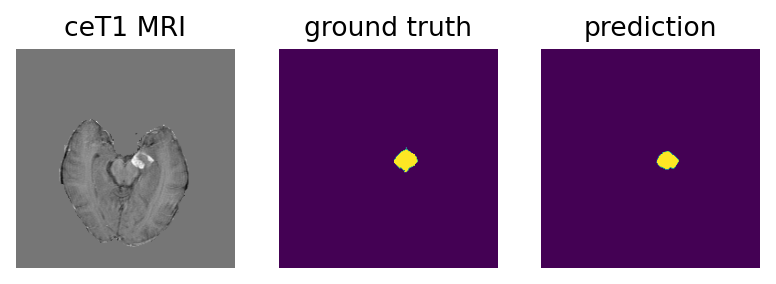

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA04_437_1_pro/t1ce.nii.gz']


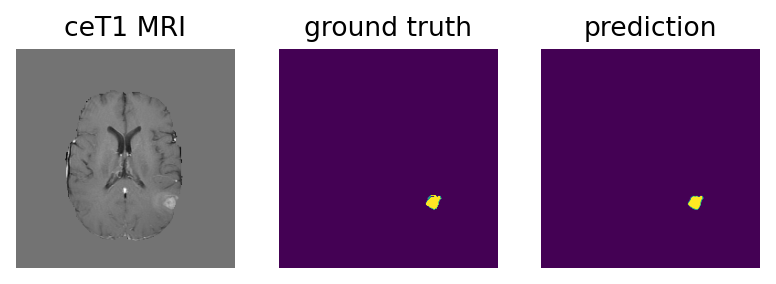

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA05_277_1_pro/t1ce.nii.gz']


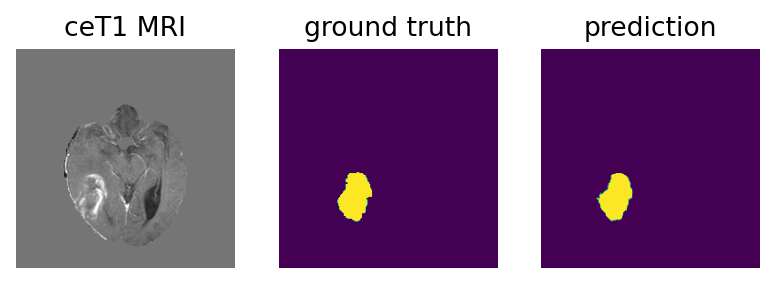

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA05_444_1_pro/t1ce.nii.gz']


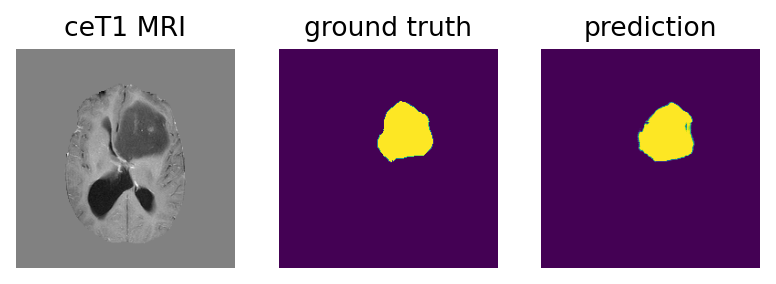

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA06_165_1_pro/t1ce.nii.gz']


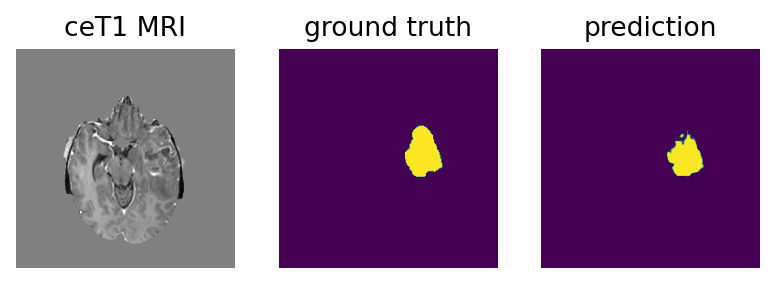

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA06_211_1_pro/t1ce.nii.gz']


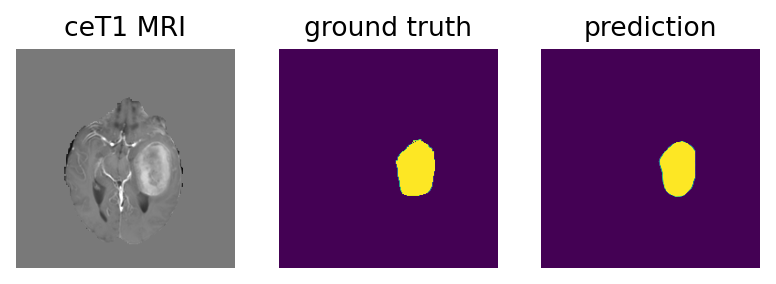

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA06_332_1_pro/t1ce.nii.gz']


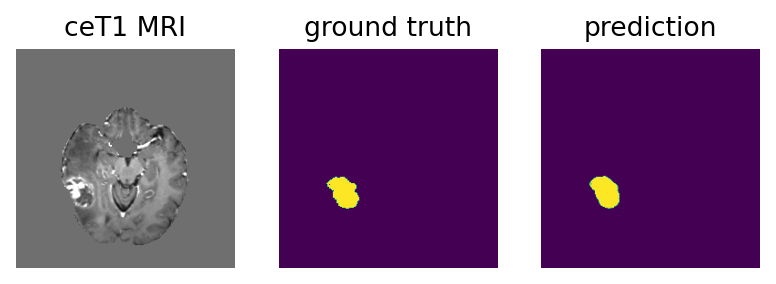

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_105_1_pro/t1ce.nii.gz']


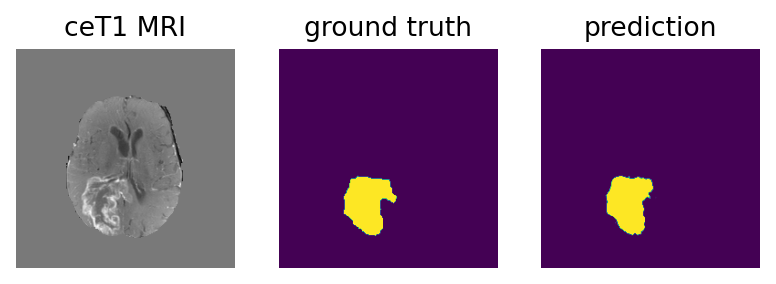

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_162_1_pro/t1ce.nii.gz']


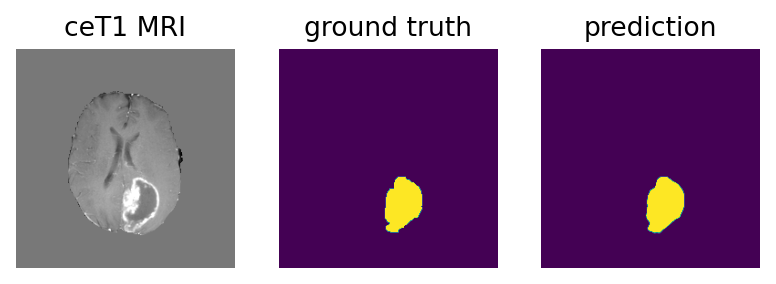

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_205_1_pro/t1ce.nii.gz']


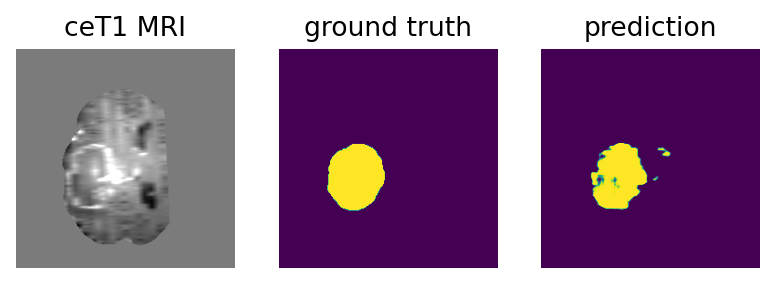

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_234_1_pro/t1ce.nii.gz']


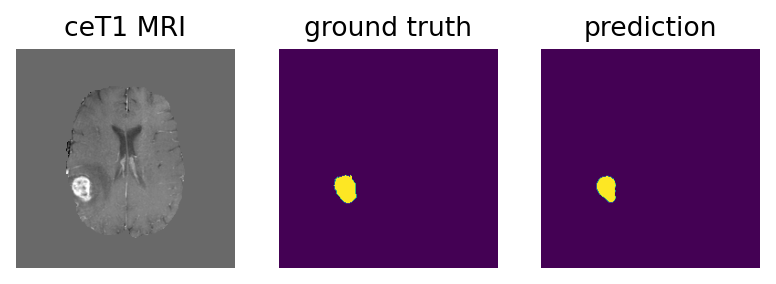

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_278_1_pro/t1ce.nii.gz']


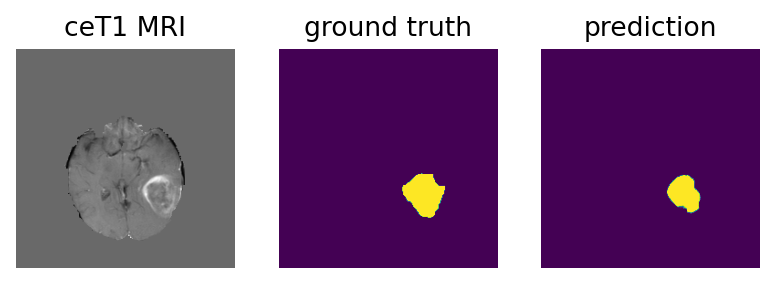

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_TCIA08_319_1_pro/t1ce.nii.gz']


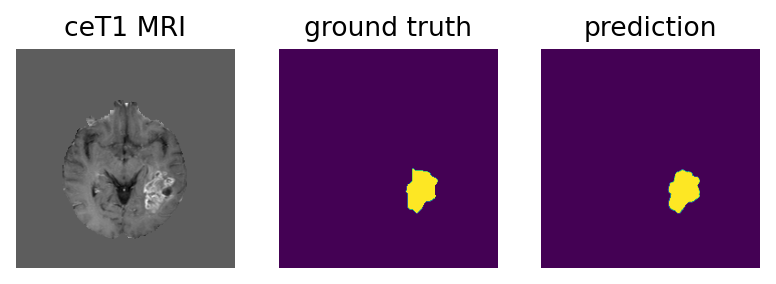

In [ ]:
model.eval()
flag_save = 1

for val_data in val_test_data:
  with torch.no_grad():
    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"],
                    )        
    val_labels = (val_labels==1).type(torch.FloatTensor)  + (val_labels==4).type(torch.FloatTensor)
    val_labels[val_labels>0] = 1
    val_labels = val_labels.to(device)
    roi_size = (160, 160, 64)
    sw_batch_size = 4
    val_outputs = sliding_window_inference(
    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
    val_loss = loss_function(val_outputs, val_labels)

    
    print(val_data['image_meta_dict']['filename_or_obj'])
    zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
    val_preds = val_outputs.softmax(1)
    plt.figure(dpi=dpiv*2)
    plt.subplot(131)
    plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
    plt.axis('off')
    plt.title('ceT1 MRI')
    plt.subplot(132)
    plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('ground truth')
    plt.subplot(133)
    plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('prediction')
    plt.show()

    if flag_save == 1:
      val_seg = torch.argmax(val_preds.cpu(),dim=1).numpy()
      pid = val_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
      h = nib.load(val_data['image_meta_dict']['filename_or_obj'][0])
      h_new=nib.Nifti1Image(val_seg[0],h.affine,h.header)
      nib.save(h_new,os.path.join(path_out,pid+'.nii.gz'))


['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_13_1/t1ce.nii.gz']


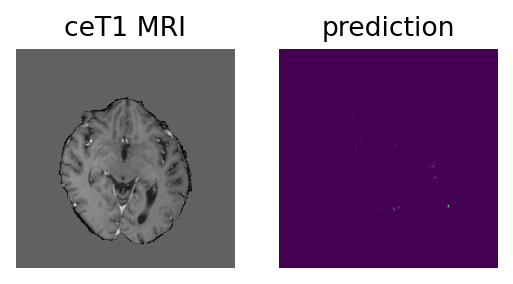

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_19_1/t1ce.nii.gz']


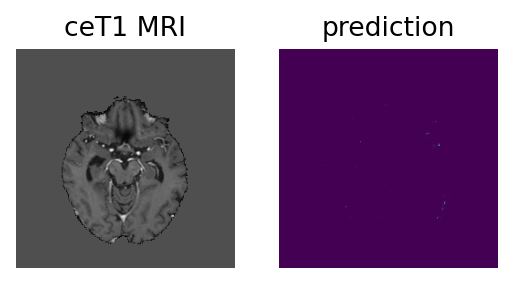

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_4_1/t1ce.nii.gz']


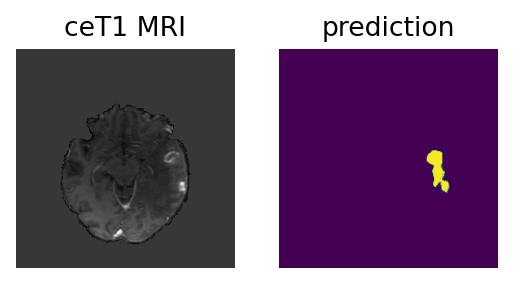

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_7_1/t1ce.nii.gz']


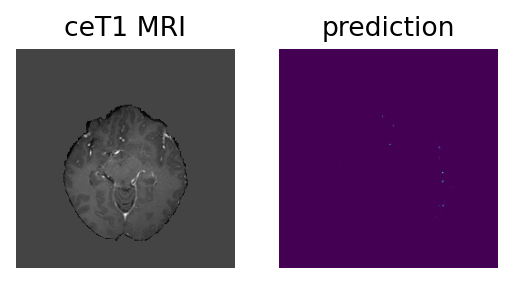

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_23_1/t1ce.nii.gz']


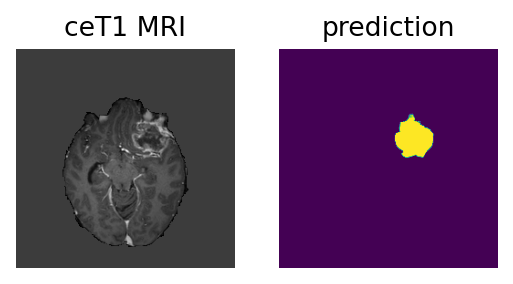

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_26_1/t1ce.nii.gz']


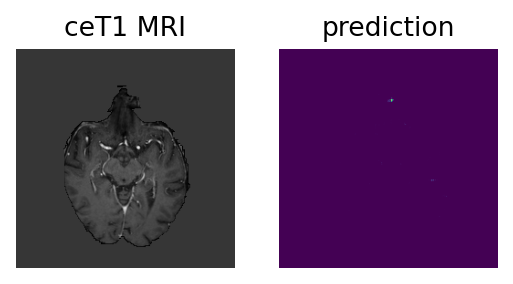

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_17_1/t1ce.nii.gz']


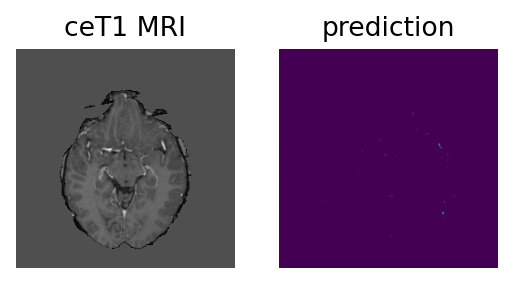

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_11_1/t1ce.nii.gz']


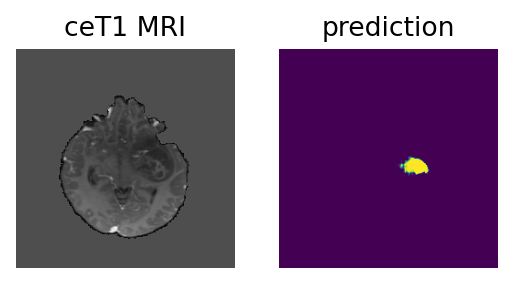

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_21_1/t1ce.nii.gz']


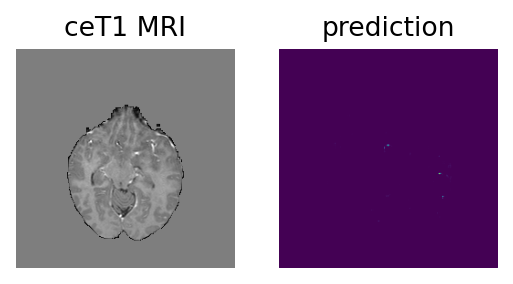

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_2013_2_1/t1ce.nii.gz']


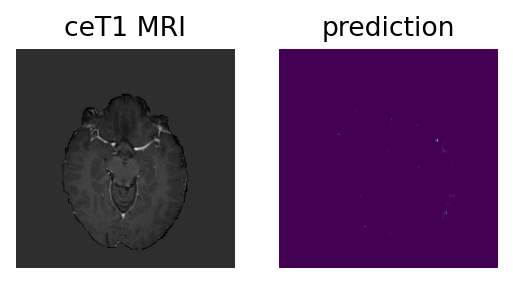

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_ALN_1/t1ce.nii.gz']


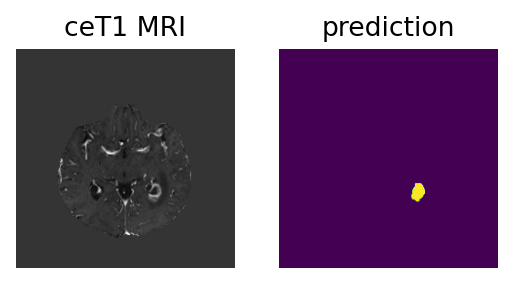

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_ABB_1/t1ce.nii.gz']


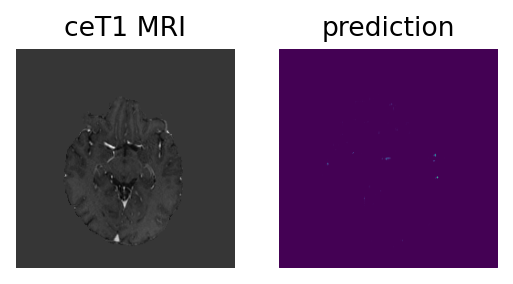

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_AAL_1/t1ce.nii.gz']


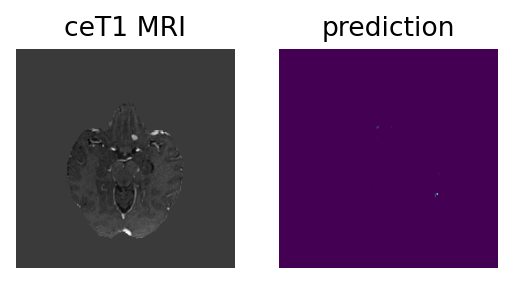

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_AMH_1/t1ce.nii.gz']


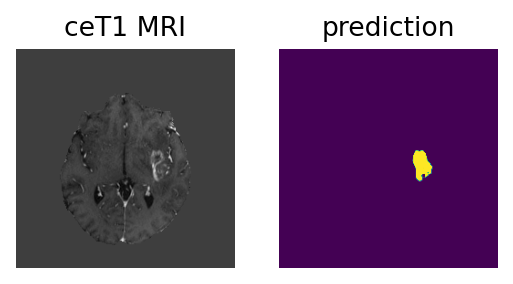

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_ANZ_1/t1ce.nii.gz']


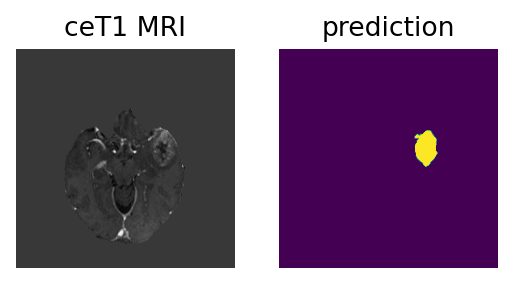

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_ABO_1/t1ce.nii.gz']


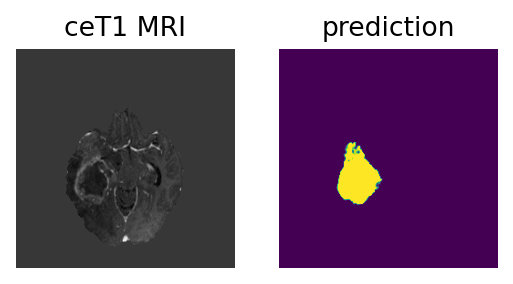

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_ANI_1/t1ce.nii.gz']


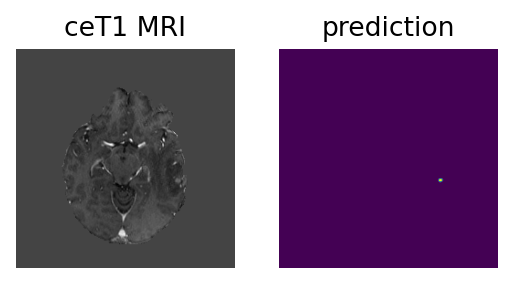

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_AAB_1/t1ce.nii.gz']


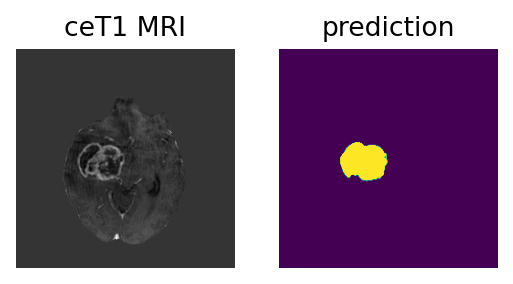

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_ALX_1/t1ce.nii.gz']


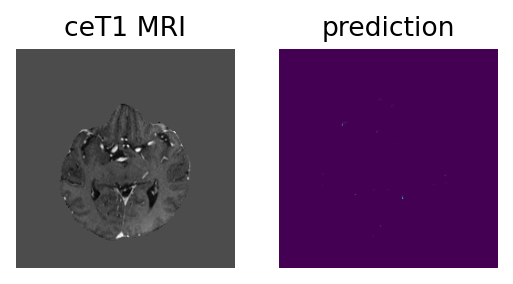

['/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem/Brats18_CBICA_ABM_1/t1ce.nii.gz']


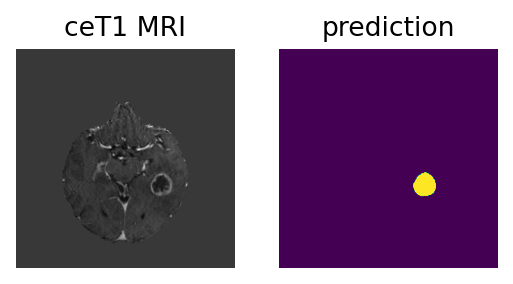

In [ ]:
model.eval()
flag_save = 1

for test_data in test_data:
  with torch.no_grad():
    ts_inputs = test_data["image"].to(device)

    #여기 
    #constrast 올리고 


    #val_labels = (val_labels==1).type(torch.FloatTensor)  + (val_labels==4).type(torch.FloatTensor)
    #val_labels[val_labels>0] = 1
    #val_labels = val_labels.to(device)
    roi_size = (160, 160, 64)
    sw_batch_size = 4
    ts_outputs = sliding_window_inference(
    ts_inputs, roi_size, sw_batch_size, model, overlap=0.75)
    #val_loss = loss_function(val_outputs, val_labels)

    
    print(test_data['image_meta_dict']['filename_or_obj'])
    #zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
    ts_preds = ts_outputs.softmax(1)
    plt.figure(dpi=dpiv*2)
    plt.subplot(131)
    plt.imshow(np.transpose(ts_inputs[0,0,:,:,60].cpu().numpy(),(1,0)),cmap='gray')
    plt.axis('off')
    plt.title('ceT1 MRI')
    #plt.subplot(132)
    #plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
    #plt.axis('off')
    #plt.title('ground truth')
    plt.subplot(132)
    plt.imshow(np.transpose(ts_preds[0,1,:,:,60].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('prediction')
    plt.show()

    if flag_save == 1:
      val_seg = torch.argmax(val_preds.cpu(),dim=1).numpy()
      pid = val_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
      h = nib.load(val_data['image_meta_dict']['filename_or_obj'][0])
      h_new=nib.Nifti1Image(val_seg[0],h.affine,h.header)
      nib.save(h_new,os.path.join(path_out,pid+'.nii.gz'))
